In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [34]:
from src.experiment import Experiment
from src.pycv.dmcp import dm_to_world
mesh_path = "/home/julian/uni/ushichka-registration/data/formatted/lidar_roi.ply"
mesh_path = "C:/Users/Julian/Nextcloud/Uni/Semester 8/ushichka-registration/data/formatted/lidar_roi.ply"
pvMesh = pv.read(mesh_path)

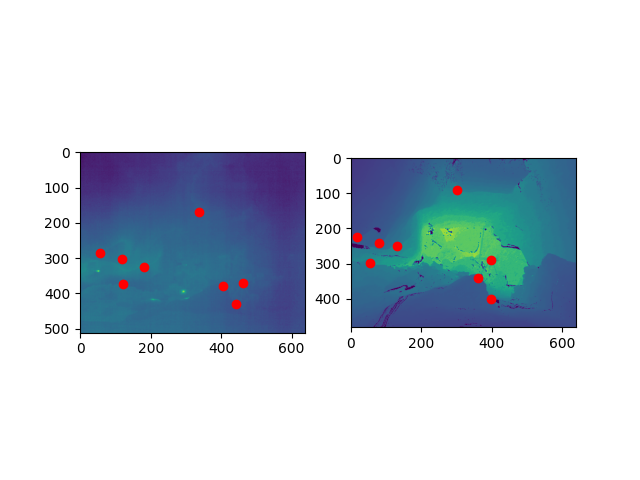

In [45]:
exp = Experiment( "/data/dmcp_experiments/dmcp_original", mesh_path)

imIm = exp.load_imIm()
imK = exp.load_imK()
imP = exp.load_imP()

dmIm = exp.load_dmIm()
dmK = exp.load_dmK()
dmP = exp.load_dmP()

cps = exp.load_cps()
pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])

trans = exp.load_transform()

#print(cps)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r")
plt.subplot(1,2,2)
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r")
plt.show()

In [46]:
plotter = pv.Plotter(notebook=False)
posM = pv.PolyData(np.array(pts_world))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.show()

# transform all cameras in scene

In [50]:
from src.pyushichka import loadCalibration

ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")]
pts = []
for cam in ps:
    K, P = cam
    P_trans = P @ la.inv(trans)
    pos = (la.null_space(P_trans) / la.null_space(P_trans)[-1])[:3].flatten()
    pts.append(pos)

pts = np.array(pts)
plotter = pv.Plotter(notebook=False)
posM = pv.PolyData(np.array(pts))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.show()

In [78]:
from src.pycv.perspective import solve_PnP
import cv2
def dmcp(K_native: np.ndarray,P_native: np.ndarray, box_native_x_native: np.ndarray, box_world: np.ndarray, return_raw_pose=False):
    # box is annotated points
    if P_native.shape != (3,4):
        raise Exception(f"P_native shape must be 3,4 bit is {P_native.shape}")

    if K_native.shape != (3,3):
        raise Exception("K_native shape must be 3,3")

    if box_native_x_native.shape[1] != 2:
        raise Exception("box_native_x_native must have 2 columns")

    if box_world.shape[1] != 3:
        raise Exception("box_world must have 3 columns")

    
    def estimate_scaling(K1, P1, K2, P2):
        E1 = np.vstack((la.inv(K1) @ P1, [0, 0, 0, 1]))
        E2 = np.vstack((la.inv(K2) @ P2, [0, 0, 0, 1]))

        # ref: https://math.stackexchange.com/questions/237369/given-this-transformation-matrix-how-do-i-decompose-it-into-translation-rotati/417813
        sv_1 = [la.norm(E1[0:3, 0]), la.norm(E1[0:3, 1]), la.norm(E1[0:3, 2])] # vector of each norm of column in rotation matrix
        sv_2 = [la.norm(E2[0:3, 0]), la.norm(E2[0:3, 1]), la.norm(E2[0:3, 2])]

        sv_1= np.array(sv_1)
        sv_2 = np.array(sv_2)

        scale_factor = la.norm(sv_2) / la.norm(sv_1)
        return scale_factor





    # DMCP Step 1 calibrate camera in world space using annotations
    pose_matrix = solve_PnP(box_world,box_native_x_native,K_native)
    raw_pose = pose_matrix.copy()
    #P = calibrate_dlt(box_native_x_native, box_world)
    #extr = la.inv(K_native) @ P
    #extr_hat = np.vstack((extr,[0,0,0,1]))
    #pose_matrix = la.inv(extr_hat)[:3,:]

    # estimated pose
    print("estimated pose"),
    print(pose_matrix)
    pose_matrix_hat = np.vstack((pose_matrix, [0,0,0,1]))
    extrinsic_matrix_world = la.inv(pose_matrix_hat)[:3,:]
    P = K_native @ extrinsic_matrix_world

    # DMCP Step 2 compute registering transform
    # DMCP Step 2.1 transform world points into camera space
    
    scale_factor = estimate_scaling(K_native,P,K_native, P_native)
    print(f"scale factor {scale_factor}")

    box_world_hat = np.hstack((box_world, np.ones((box_world.shape[0],1))))
    box_world_camera = np.matmul(extrinsic_matrix_world, box_world_hat.T).T * scale_factor

    # DMCP Step 2.2 transform camera points into native space
    extrinsic_matrix_native = np.matmul(la.inv(K_native), P_native)
    extrinsic_matrix_native_hat = np.vstack((extrinsic_matrix_native,[0,0,0,1]))
    pose_matrix = la.inv(extrinsic_matrix_native_hat)
    camera_pose_matrix_native = pose_matrix

    box_world_camera_hat = np.hstack((box_world_camera,np.ones((box_world_camera.shape[0],1))))
    box_native_tf = np.matmul(camera_pose_matrix_native, box_world_camera_hat.T).T[:,:3]

    # DMCP Step 2.3
    retval, scale = cv2.estimateAffine3D(box_native_tf, box_world,force_rotation=True)
    A_tf = retval
    A_tf[:3,:3] = A_tf[:3,:3]* scale
    print(scale)

    A_tf_hat = np.vstack((A_tf,[0,0,0,1]))

    #print("retval\n",retval,"scale\n", scale)
    if return_raw_pose:
        return raw_pose, A_tf_hat

    return A_tf_hat

A = dmcp(imK, imP, cps[:,:2], pts_world)
ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")]
pts = []
for cam in ps:
    K, P = cam
    P_trans = P @ la.inv(A)
    pos = (la.null_space(P_trans) / la.null_space(P_trans)[-1])[:3].flatten()
    pts.append(pos)

pts = np.array(pts)
plotter = pv.Plotter(notebook=False)
posM = pv.PolyData(np.array(pts))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.show()

estimated pose
[[      0.46      -0.35      -0.82       1.91]
 [      0.89       0.20       0.41      -1.08]
 [      0.01      -0.91       0.40      -1.63]]
scale factor 0.1964607903350714
0.745587618494912
